# Bias and Variance trade off in Linear Regression 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn import metrics 
from sklearn import ensemble 
from sklearn.linear_model import Lasso, Ridge 

In [3]:
#loading train data of houses
df_data = pd.read_csv('train.csv')
df_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print(df_data.columns)
print(df_data.shape)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
#dealing with the null values 

In [6]:
total = df_data.isnull().sum().sort_values(ascending=False)
percent = (df_data.isnull().sum()/df_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Percent'])

In [7]:
missing_data

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
...,...,...
CentralAir,0,0.000000
SaleCondition,0,0.000000
Heating,0,0.000000
TotalBsmtSF,0,0.000000


In [8]:
# drop the columns having more than 15% of null values. So the columns till ‘LotFrontage’ 
# can be removed. If we check the columns like ‘GarageXXXX’ they seem to be related with 
# Garage area and we can remove them as well are they are collinear. Similar case with 
# ‘BsmtXXX’ and ‘MasVnrXXXX’. For ‘Electrical’ there is only one datapoint that is null. 
#So we can remove that specific row from the data.

In [9]:
df_data = df_data.drop(missing_data[missing_data['Total']>1].index.values,1)
df_data = df_data.drop(df_data.loc[df_data['Electrical'].isnull()].index)
len(df_data.columns)

63

<AxesSubplot:>

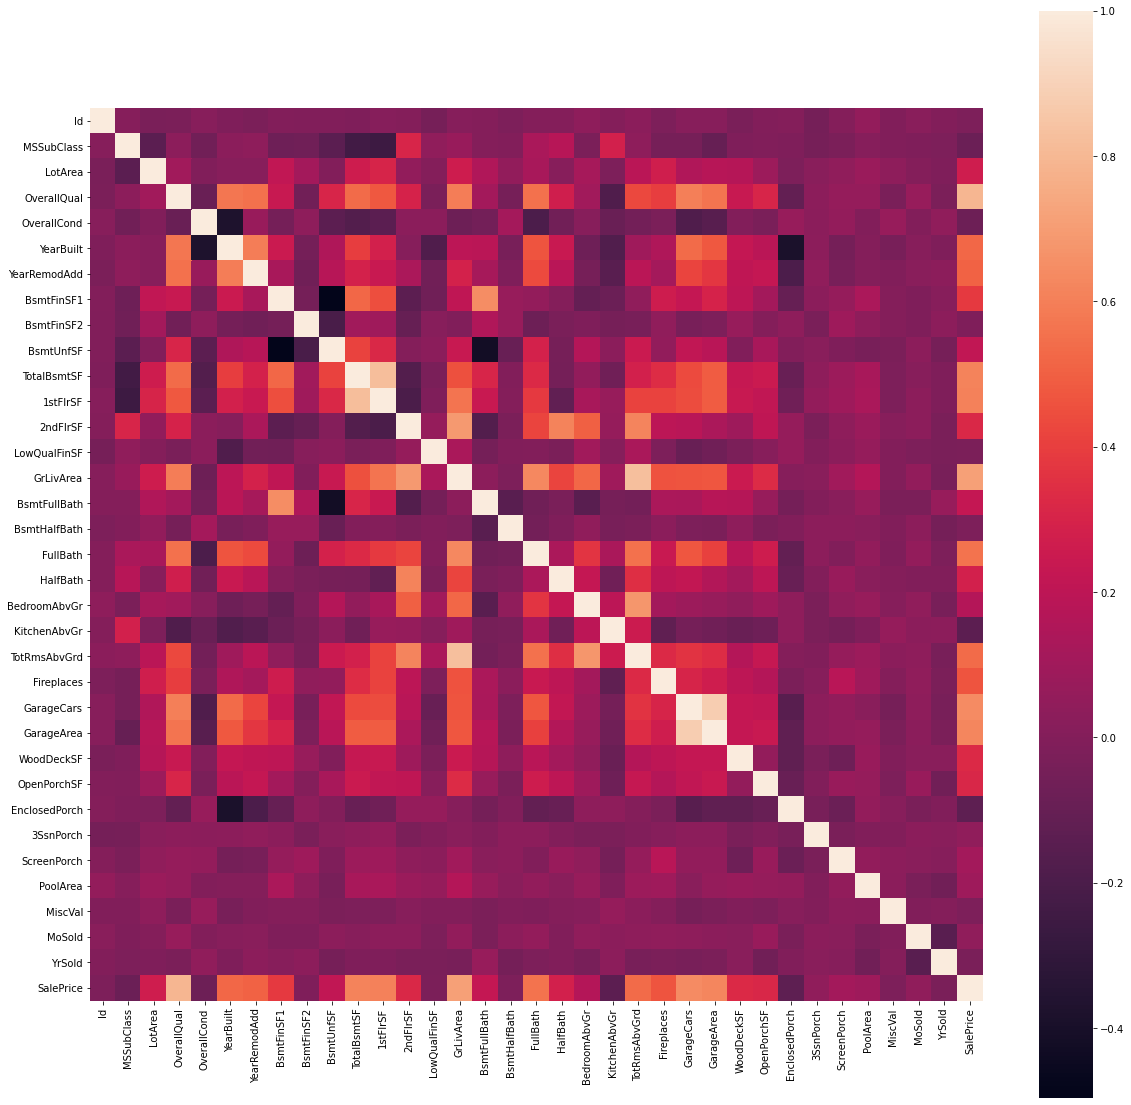

In [10]:
#checking correlation 
corr_mat = df_data.corr()

fi, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr_mat, square=True)

Though column ‘ID’ seems to have no correlation to all the columns but there is no use in modelling as its just row number. So we can remove it too

In [11]:
del df_data['Id']

In [13]:
len(df_data.columns)

62

There are many columns that are categorical. We need to one hot encode them.

In [14]:
le = LabelEncoder()
cat_mask = df_data.dtypes == 'object'
cat_cols = df_data.columns[cat_mask].tolist()
cat_cols

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [16]:
# converting the columns to one hot encoding

df_data[cat_cols] = df_data[cat_cols].apply(lambda x: le.fit_transform(x.astype(str)))
df_data_c = df_data.copy()

#get dummies is used for one hot encoding
df_data_c = pd.get_dummies(df_data_c, columns = cat_cols)

In [17]:
df_data_c.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,60,8450,7,5,2003,2003,706,0,150,856,...,0,0,0,1,0,0,0,0,1,0
1,20,9600,6,8,1976,1976,978,0,284,1262,...,0,0,0,1,0,0,0,0,1,0
2,60,11250,7,5,2001,2002,486,0,434,920,...,0,0,0,1,0,0,0,0,1,0
3,70,9550,7,5,1915,1970,216,0,540,756,...,0,0,0,1,1,0,0,0,0,0
4,60,14260,8,5,2000,2000,655,0,490,1145,...,0,0,0,1,0,0,0,0,1,0


split the data into train and test.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(df_data_c.drop('SalePrice', axis=1),
                                                   df_data_c['SalePrice'], test_size = 0.25, 
                                                   random_state=120)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [21]:
# normalising the values in train and test using Standard Scaler function

sc_X = StandardScaler()
sc_Y = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.fit_transform(x_test)
y_train = sc_X.fit_transform(y_train)
y_test = sc_Y.fit_transform(y_test)

In [30]:
# fitting regression model 

lr = LinearRegression()
lr.fit(x_train, y_train)

#predictions on train data
x_pred = lr.predict(x_train)
x_pred = x_pred.reshape(-1,1)

#predictions on validation data
y_predictions = lr.predict(x_test)
y_predictions = y_predictions.reshape(-1,1)

def scores_(y,x):
    print('MAE:', metrics.mean_absolute_error(y, x))
    print('MSE:', metrics.mean_squared_error(y, x))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, x)))
    print('R2 Score:' ,metrics.r2_score(y,x))

print('InSample_accuracy')
scores_(y_train, x_pred)
print('---------------------------')
print('OutSample_accuracy')
scores_(y_test,y_predictions)

InSample_accuracy
MAE: 0.1868224512398815
MSE: 0.08261009382825488
RMSE: 0.28741971718769554
R2 Score: 0.9173899061717451
---------------------------
OutSample_accuracy
MAE: 1864083698980.7788
MSE: 2.3498205525764755e+25
RMSE: 4847494767997.667
R2 Score: -2.3498205525764755e+25


The model performed really well on training data with a good 0.92 r2 score and <1 RMSE score but with test data the performance is no where near good. This is a clear overfitting model. Reason might me because of numerous features. To tackle this we can perform Ridge and Lasso regularization.

## Lasso or l1 regularization 

    alpha  rmse_score_train  rmse_score_test  r2_score_train  r2_score_test
0   0.001          0.348728         0.326784        0.878389       0.893212
1   0.002          0.404388         0.372998        0.836470       0.860872
2   0.003          0.456628         0.413701        0.791491       0.828851
3   0.004          0.502721         0.450026        0.747272       0.797476
4   0.005          0.533838         0.482514        0.715017       0.767180
5   0.006          0.559009         0.513262        0.687509       0.736562
6   0.007          0.583801         0.543181        0.659177       0.704954
7   0.008          0.606706         0.570918        0.631908       0.674052
8   0.009          0.630847         0.599956        0.602032       0.640052
9   0.010          0.656766         0.630438        0.568659       0.602547
10  0.011          0.682314         0.659750        0.534448       0.564730
11  0.012          0.705194         0.685245        0.502701       0.530439
12  0.013   

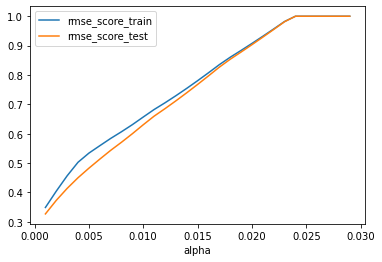

In [38]:
def regularization(model, alpha_range):
    rmse_score_train = []
    rmse_score_test = []
    r2_score_train = []
    r2_score_test = []
    
    for i in alpha_range:
        regularization = model(alpha=i, normalize=True)
        regularization.fit(x_train, y_train)
        y_pred_train = regularization.predict(x_train)
        y_pred_train = y_pred_train.reshape(-1,1)
        y_pred_test=regularization.predict(x_test)
        y_pred_test = y_pred_test.reshape(-1,1)
        
        rmse_score_train.append(np.sqrt(metrics.mean_squared_error(y_train,y_pred_train )))
        rmse_score_test.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
        r2_score_train.append(metrics.r2_score(y_train, y_pred_train))
        r2_score_test.append(metrics.r2_score(y_test, y_pred_test))
    
    df=pd.DataFrame()
    df['alpha']=alpha_range
    df['rmse_score_train'] = rmse_score_train
    df['rmse_score_test']= rmse_score_test 
    df['r2_score_train'] = r2_score_train
    df['r2_score_test'] = r2_score_test
    
    print(df)
    
    return df.plot(x = 'alpha', y = ['rmse_score_train', 'rmse_score_test'])

alpha_range_lasso = np.arange(0.001,0.03,0.001)
print(regularization(Lasso,alpha_range_lasso))

can see that there is no huge difference in train and test. RMSE scores so Lasso has resolved overfitting. One observation here is that after alpha= 0.017 there is no difference in RMSE scores of train and test.

## Ridge or l2 regularization

   alpha  rmse_score_train  rmse_score_test  r2_score_train  r2_score_test
0  0.001          0.284263         0.314329        0.919195       0.901197
1  0.101          0.293603         0.293155        0.913797       0.914060
2  0.201          0.304623         0.289957        0.907205       0.915925
3  0.301          0.314831         0.291153        0.900882       0.915230
4  0.401          0.324181         0.294293        0.894907       0.913392
5  0.501          0.332788         0.298431        0.889252       0.910939
6  0.601          0.340770         0.303116        0.883875       0.908121
7  0.701          0.348225         0.308104        0.878739       0.905072
8  0.801          0.355231         0.313253        0.873811       0.901873
9  0.901          0.361850         0.318476        0.869064       0.898573
AxesSubplot(0.125,0.125;0.775x0.755)


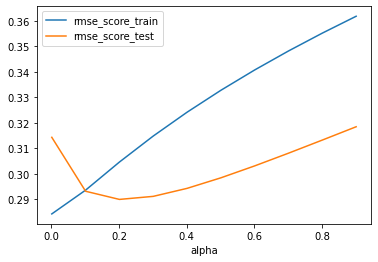

In [39]:
alpha_range_ridge = np.arange(0.001,1,0.1)
print(regularization(Ridge,alpha_range_ridge))
#writing functions helps reduce redundant lines of code as seen #above we can just input the parametre 
#Ridge or Lasso

We see in the graph that around alpha=0.1 there is no much difference in the RMSE scores and clearly there is no sign of over fitting as there is very less difference of train and test RMSE scores as compared to huge difference in Linear Regression.